In [1]:
import pandas as pd
import numpy as np
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
warnings.filterwarnings('ignore')

import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

C:\Users\Trader\AppData\Local\Temp\ipykernel_3768\804097999.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\Users\Trader\anaconda3\envs\iod_dl\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf

In [4]:
bhp = yf.Ticker("BHP.AX")

In [5]:
print(bhp.info)

{'zip': '3000', 'sector': 'Basic Materials', 'fullTimeEmployees': 40110, 'longBusinessSummary': 'BHP Group Limited operates as a resources company in Australia, Europe, China, Japan, India, South Korea, rest of Asia, North America, South America, and internationally. It operates through Petroleum, Copper, Iron Ore, and Coal segments. The company engages in the exploration, development, and production of oil and gas properties; and mining of copper, silver, zinc, molybdenum, uranium, gold, iron ore, and metallurgical and energy coal. It is also involved in mining, smelting, and refining of nickel; and potash development activities. In addition, the company provides towing, freight, marketing and trading, marketing support, finance, administrative, and other services. The company was founded in 1851 and is headquartered in Melbourne, Australia.', 'city': 'Melbourne', 'phone': '61 3 9609 3333', 'state': 'VIC', 'country': 'Australia', 'companyOfficers': [], 'website': 'https://www.bhp.com'

In [6]:
hist = bhp.history(period='1Y')

In [7]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-03-15,42.947822,43.217538,42.417380,43.046719,5006262,0.0,0
2021-03-16,42.363432,42.866904,42.102709,42.111698,6968502,0.0,0
2021-03-17,41.680156,41.877949,41.329526,41.419430,7261879,0.0,0
2021-03-18,41.014852,41.536305,40.996870,41.077785,5934005,0.0,0
2021-03-19,40.475420,40.826051,40.115797,40.367535,14895557,0.0,0


In [8]:
bhp = hist['Close']

In [9]:
bhp.head()

Date
2021-03-15    43.046719
2021-03-16    42.111698
2021-03-17    41.419430
2021-03-18    41.077785
2021-03-19    40.367535
Name: Close, dtype: float64

In [10]:
bhp.tail()

Date
2022-03-08    48.529999
2022-03-09    48.490002
2022-03-10    47.750000
2022-03-11    47.689999
2022-03-14    47.709999
Name: Close, dtype: float64

In [12]:
bhp.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 254 entries, 2021-03-15 to 2022-03-14
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
254 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


In [13]:
bhp.shape

(254,)

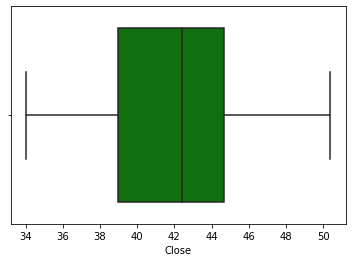

In [14]:
sns.boxplot(bhp, color='g');

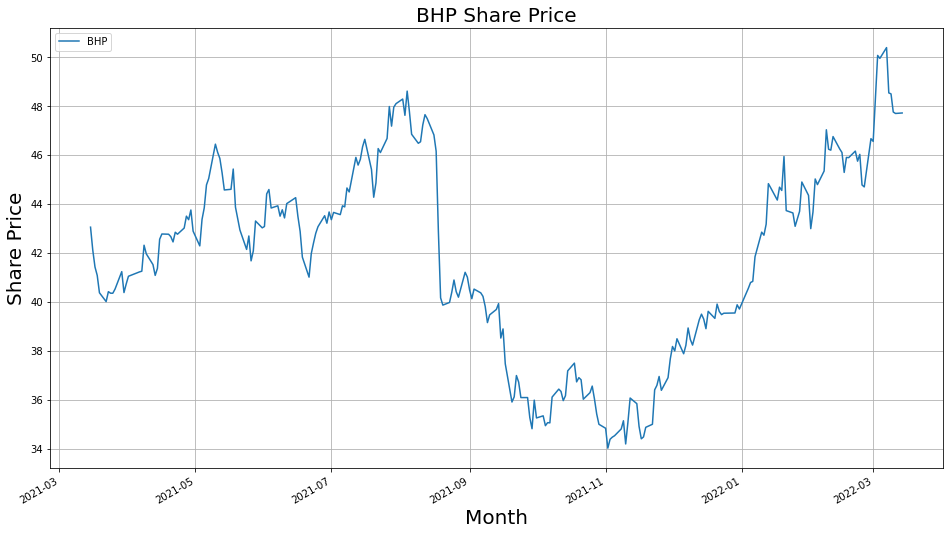

In [15]:
bhp.plot(label='BHP', figsize=(16, 9))
plt.xlabel('Month', fontsize=20)
plt.title('BHP Share Price', fontsize=20)
plt.ylabel('Share Price', fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

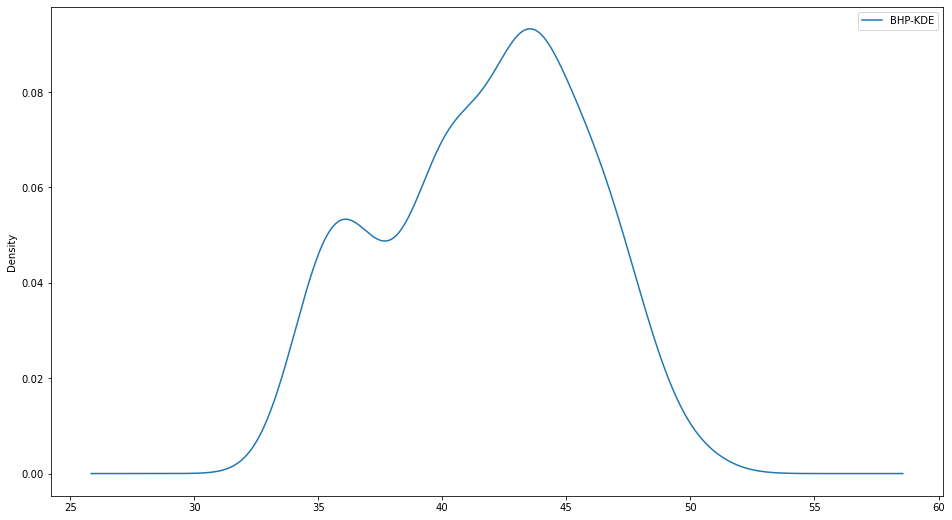

In [16]:
df_close = bhp
df_close.plot(kind='kde', label='BHP-KDE', figsize=(16,9))
plt.legend()
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

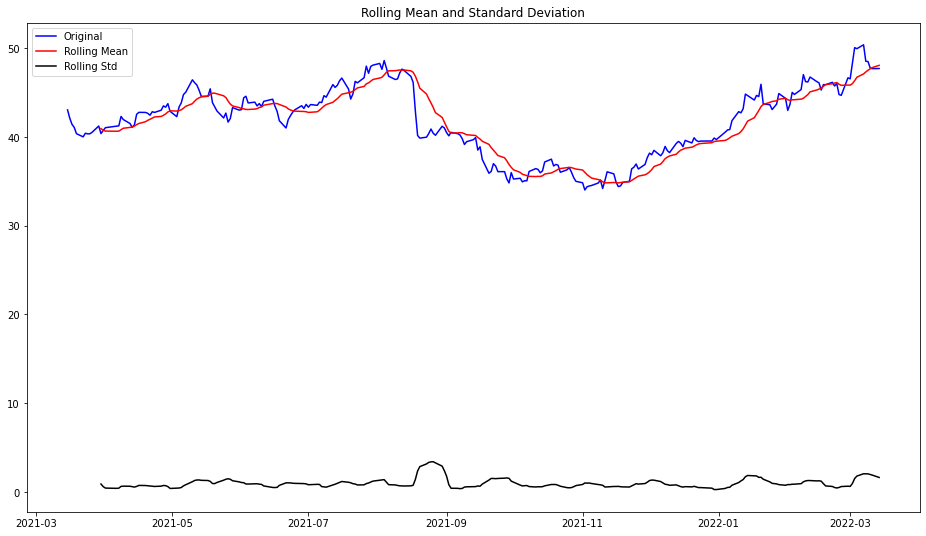

Results of dickey fuller test
Test Statistics                 -1.243220
p-value                          0.654733
No. of lags used                 1.000000
Number of observations used    252.000000
critical value (1%)             -3.456569
critical value (5%)             -2.873079
critical value (10%)            -2.572919
dtype: float64


In [18]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16, 9))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(bhp)

<Figure size 432x288 with 0 Axes>

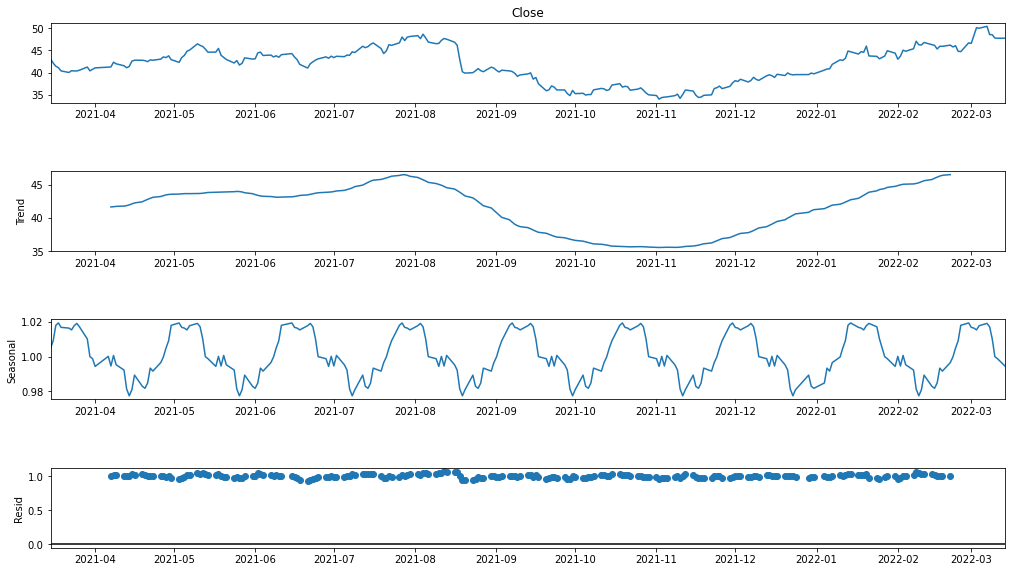

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


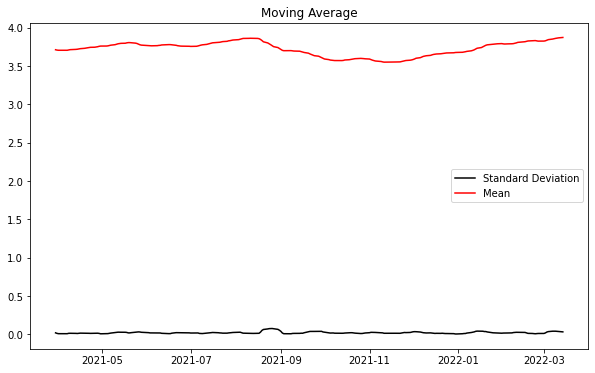

In [20]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

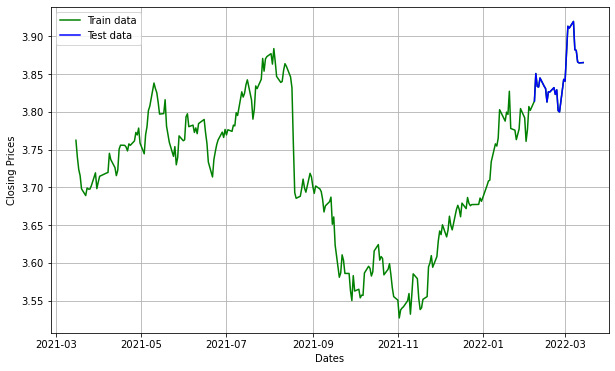

In [21]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

In [22]:
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1182.959, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1182.830, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1183.119, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1184.845, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1181.629, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.733 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 593.423
Date:                Mon, 14 Mar 2022   AIC                          -1184.845
Time:                        10:29:06   BIC                          -1181.433
Sample:                             0   HQIC                         -1183.468
                                - 225                                  

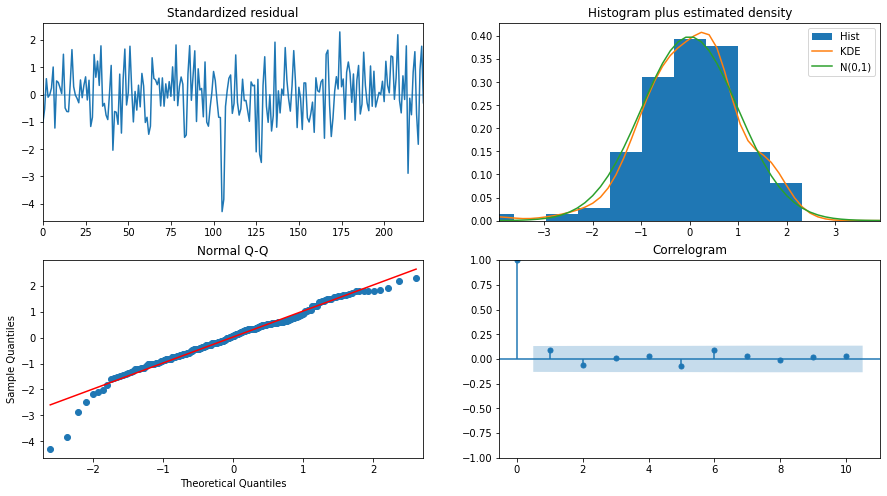

In [23]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [24]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 596.870
Date:                Mon, 14 Mar 2022   AIC                          -1185.739
Time:                        10:29:10   BIC                          -1172.075
Sample:                             0   HQIC                         -1180.224
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7126      0.070     53.283      0.000       3.576       3.849
ar.L1          0.9814      0.013     77.702      0.000       0.957       1.006
ma.L1          0.1076      0.054      2.002      0.0

In [25]:
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

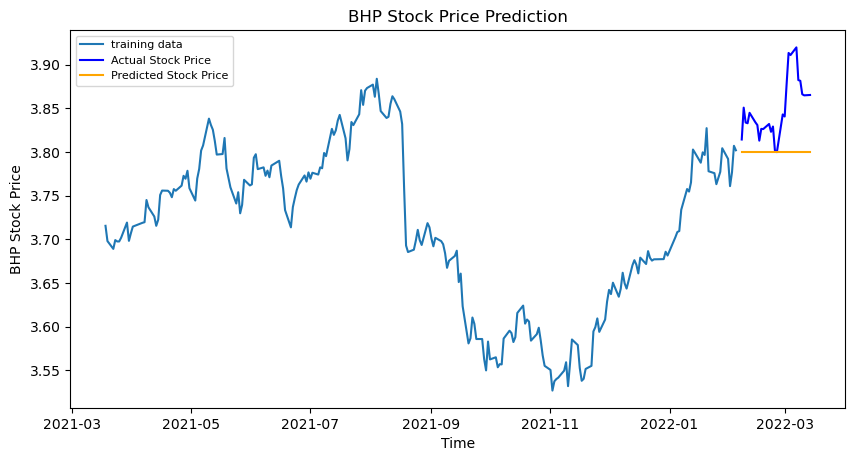

In [35]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('BHP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BHP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(fc-test_data)/np.abs(test_data))  # MAPE
    me = np.mean(fc - test_data)             # ME
    mae = np.mean(np.abs(fc - test_data))    # MAE
    mpe = np.mean((fc - test_data)/test_data)   # MPE
    rmse = np.mean(np.abs(fc - test_data)/np.abs(test_data))  # RMSE
#    corr = np.corrcoef(forecast, actual)[0,1]   # corr
#    mins = np.amin(np.hstack([forecast[:,None], 
#                              actual[:,None]]), axis=1)
#    maxs = np.amax(np.hstack([forecast[:,None], 
#                              actual[:,None]]), axis=1)
#    minmax = 1 - np.mean(mins/maxs)             # minmax
#    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            })

forecast_accuracy(fc, test_data)

{'mape': 0.012605116106441959,
 'me': -0.048777731050234745,
 'mae': 0.048777731050234745,
 'mpe': -0.012605116106441959,
 'rmse': 0.012605116106441959}

In [ ]:
from platform import python_version

print(python_version())